## 1) Install some dependencies and then Ultralytics

In [ ]:
%pip install -U pip
%pip install -U torch==1.13.1 torchvision
%pip install sagemaker-studio-image-build

In [ ]:
import os
if not os.path.isdir('ultralytics'):
    !git clone https://github.com/ultralytics/ultralytics && \
    cd ultralytics && \
    git checkout 10eb0b6229

In [ ]:
%pip install -r ultralytics/requirements.txt

### 1.1) Download pre-trained weights for Segmentation

In [ ]:
import os
import urllib
if not os.path.isfile("yolov8s-seg.pt"):
    urllib.request.urlretrieve(
        "https://github.com/ultralytics/assets/releases/download/v0.0.0/yolov8s-seg.pt",
        "yolov8s-seg.pt"
    )

## 2) Load the model and export it to ONNX

In [ ]:
import os
import sys
if not "ultralytics" in sys.path: sys.path.append("ultralytics")
from ultralytics import YOLO

model = YOLO('yolov8s-seg.pt')
model.export(format='onnx', imgsz=640, simplify=True)

## 3) Build a custom Docker image for ONNXRuntime
# You need to run Section 3 once
## Skip it next time you run this notebook if you didn't modify the container

In [ ]:
import os
import boto3
import tarfile
import sagemaker

image_tag="1.14.1"
image_name="onnxruntime"

account_id = boto3.client('sts').get_caller_identity().get('Account')
sagemaker_sess = sagemaker.Session()
sagemaker_role = sagemaker.get_execution_role()
bucket = sagemaker_sess.default_bucket()
region = sagemaker_sess.boto_session.region_name
image_uri=f"{account_id}.dkr.ecr.{region}.amazonaws.com/{image_name}:{image_tag}"

if not os.path.isdir('container'): os.makedirs('container', exist_ok=True)
print(f"Bucket: {bucket}\nAWS Account: {account_id}\nRegion: {region}")
print(f"Container image uri: {image_uri}")

This script is the **container entrypoint**. SageMaker will invoke it immediately, after loading the container, passing the argument **serve**, when used for Inference.

This script is abstract. It means you need to implement your own handler (name it **inference.py**) and save it to the same directory you saved the model. 

In [ ]:
%%writefile container/dockerd-entrypoint.py
import io
import os
import sys
import bjoern
import importlib

from importlib.util import find_spec
from bottle import Bottle, run, request, response

if __name__=='__main__':
    if sys.argv[1] != 'serve':
        raise Exception(f"Operation not supported: {sys.argv[1]}. Expected: serve")

    user_module_name = os.environ.get('SAGEMAKER_USER_MODULE')
    model_dir  = os.path.join('opt', 'ml', 'model')
    user_module_dir = os.path.join(model_dir, 'code')
    if not user_module_dir in sys.path: sys.path.append(user_module_dir)
    
    # look for inference.py inside the model directory
    if find_spec(user_module_name) is None:
        raise Exception("You need to provide a handler file into your model deployment: inference.py")

    print("Custom module found. Loading methods")
    user_module = importlib.import_module(user_module_name)
    model_fn = getattr(user_module, "model_fn", None)
    input_fn = getattr(user_module, "input_fn", None)
    predict_fn = getattr(user_module, "predict_fn", None)
    output_fn = getattr(user_module, "output_fn", None)

    model = model_fn(model_dir)
    app = Bottle()
    # SageMaker uses this method for health check
    @app.get('/ping')
    def ping():
        return ""
    
    # Method invoked by SageMaker for model execution
    @app.post('/invocations')
    def invocations():
        data = input_fn(request.body, request.content_type)
        predictions = predict_fn(data, model)
        out = output_fn(predictions, request.headers['Accept'])
        response.content_type = request.headers['Accept']
        return out

    print("Starting server")
    bjoern.run(app, "0.0.0.0", 8080)

In [ ]:
%%writefile container/Dockerfile
FROM public.ecr.aws/amundsen-dependancies/python3.7-slim:latest

ENV SAGEMAKER_USER_MODULE="inference"

RUN pip install -U --no-cache-dir pip

RUN apt update -y && \
    apt install -y --no-install-recommends \
    libgl1 libglib2.0-0 build-essential libev-dev && \
    pip install --no-cache-dir bjoern && \
    apt autoremove -y build-essential && \
    rm -rf /var/cache/apt/

RUN pip install -U --no-cache-dir onnxruntime==1.14.1 opencv-python numpy bottle

COPY dockerd-entrypoint.py /usr/local/bin/dockerd-entrypoint.py
RUN chmod +x /usr/local/bin/dockerd-entrypoint.py

EXPOSE 8080 8081
ENTRYPOINT ["python", "/usr/local/bin/dockerd-entrypoint.py"]

### 3.1) Build the container image and push it to ECR
--> Make sure the role you're using to run this code has permission to create/push container images to ECR.

In [ ]:
!sm-docker build container \
    --repository $image_uri \
    --compute-type BUILD_GENERAL1_MEDIUM \
    --bucket $bucket    

## 4) Deploying our Serverless endpoint

In [ ]:
%%writefile inference.py
import os
import io
import cv2
import numpy as np
import onnxruntime as ort

def model_fn(model_dir):
    model = ort.InferenceSession(os.path.join(model_dir, 'yolov8s-seg.onnx'), Providers=['CPUExecutionProvider'])
    inputs = model.get_inputs()[0].name
    return model,inputs


def input_fn(input_data, content_type):
    if content_type != "image/jpeg":
        raise Exception(f"Invalid content-type {content_type}. Expected: image/jpeg")
    img = np.frombuffer(input_data.read(), dtype=np.uint8)
    img = cv2.imdecode(img, cv2.IMREAD_COLOR)
    h,w,c = img.shape
    if h!=w:
        max_size=max(h,w)
        img_sqr = np.zeros((max_size,max_size,c), dtype=np.uint8)
        img_sqr[:h,:w],img = img[:],img_sqr
    x = cv2.resize(img, (640,640))
    x = (x / 255.0).astype(np.float32)
    x = x.transpose(2,0,1)
    x = np.expand_dims(x, axis=0)
    return x

def predict_fn(data, model_inputs):
    model,inputs = model_inputs
    return model.run(None, {inputs: data})

def output_fn(predictions, accept):
    if accept != "image/png":
        raise Exception( f"Invalid Accept {accept}. Expected: image/png")
    ### TODO: run the post-processing code here and build an image with the masks
    dummy = np.zeros((160,160,1), dtype=np.uint8)
    return cv2.imencode(".png", dummy)[1].tobytes()

### 4.1) Upload the model artifacts to S3

In [ ]:
import io
import tarfile
import sagemaker

sagemaker_sess = sagemaker.Session()
bucket = sagemaker_sess.default_bucket()
print(f"Bucket: {bucket}")

with io.BytesIO() as f:
    with tarfile.open(fileobj=f, mode="w:gz") as tar:
        tar.add("yolov8s-seg.onnx")
        tar.add("inference.py", "code/inference.py")
        
        tar.list()
    f.seek(0)
    model_uri = sagemaker_sess.upload_string_as_file_body(f, bucket, "models/yolov8s-seg-onnx/model.tar.gz")
    print(model_uri)

### 4.2) Deploy the serverless endpoint

In [ ]:
import logging
from sagemaker.utils import name_from_base
from sagemaker.serverless.serverless_inference_config import ServerlessInferenceConfig

model = sagemaker.Model(
    image_uri=image_uri,
    model_data=model_uri,
    role=sagemaker_role,
    name=name_from_base('yolov8s-seg'),
    sagemaker_session=sagemaker_sess,
    container_log_level=logging.DEBUG,
    entry_point="inference.py"
)
serverless_config = ServerlessInferenceConfig(
    # https://docs.aws.amazon.com/sagemaker/latest/dg/serverless-endpoints.html#serverless-endpoints-how-it-works-memory
    memory_size_in_mb=6144,
    max_concurrency=1,
)
model.deploy(serverless_inference_config=serverless_config)

## 5) Invoke the endpoint

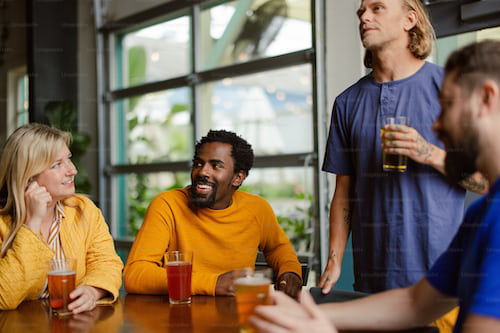

In [42]:
import os
import urllib
from PIL import Image

# get a dummy image
if not os.path.isfile('people.jpg'):
    urllib.request.urlretrieve(
        "https://plus.unsplash.com/premium_photo-1682545957433-fafe06037ac4?ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxzZWFyY2h8N3x8Y3Jvd2R8ZW58MHx8MHx8fDA%3D&auto=format&fit=crop&w=500&q=60",
        "people.jpg"
    )
Image.open('people.jpg')

In [ ]:
from sagemaker import Predictor
from sagemaker.serializers import IdentitySerializer
from sagemaker.deserializers import BytesDeserializer
predictor = Predictor(endpoint_name=model.endpoint_name, sagemaker_session = sagemaker_sess)
predictor.serializer = IdentitySerializer('image/jpeg')
predictor.deserializer = BytesDeserializer('image/png')

In [44]:
%%time
# warmup
img = open('people.jpg', 'rb').read()
y = predictor.predict(img)
## y is a black .png file
## it is just a dummy file we created in our inference.py
## You need to fully implement the output_fn method to
## get something useful here

CPU times: user 10.1 ms, sys: 194 µs, total: 10.3 ms
Wall time: 1.51 s


In [48]:
# benchmark
import time
it=10
t=time.time()
for i in range(it):
    y = predictor.predict(img)
print(f"Elapsed: AVG {(time.time()-t) * 1000 / it}ms per invocation")

Elapsed: AVG 330.0060987472534ms per invocation


### Good to know: Yolov8n-seg takes ~130ms per invocation